/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

      0 to 2       1.00      0.67      0.80         3
    10 to 20       0.50      1.00      0.67         2
      2 to 5       1.00      0.67      0.80         3
     5 to 10       0.75      0.75      0.75         4

    accuracy                           0.75        12
   macro avg       0.81      0.77      0.75        12
weighted avg       0.83      0.75      0.76        12



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:48:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Cross-validated Accuracy: 0.77


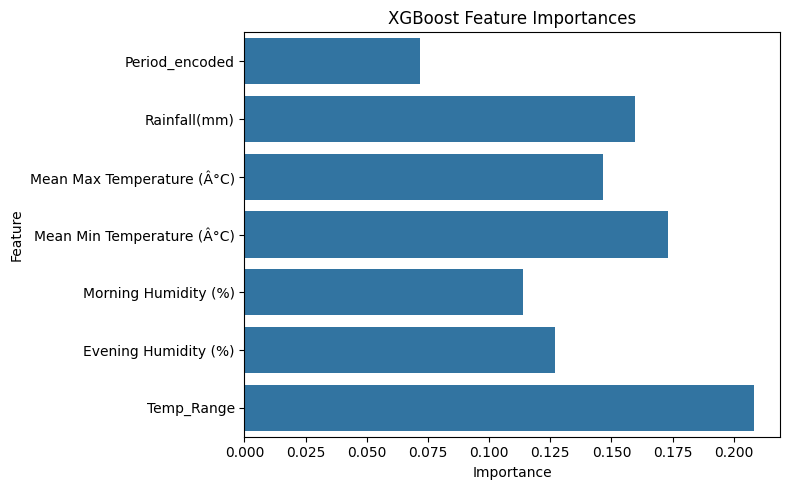

In [9]:
# Install imbalanced-learn if not already
!pip install -q imbalanced-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Step 1: Load the data
df = pd.read_csv("/content/sample_data/West_Bengal_Final_Data(in).csv", encoding="ISO-8859-1")

# Step 2: Drop missing values
df_clean = df.dropna()

# Step 3: Encode target variable
gwl_encoder = LabelEncoder()
df_clean["GWL_encoded"] = gwl_encoder.fit_transform(df_clean["GWL (In mbgl)"])

# Step 4: Encode 'Period'
period_encoder = LabelEncoder()
df_clean["Period_encoded"] = period_encoder.fit_transform(df_clean["Period"])

# Step 5: Feature engineering
df_clean["Temp_Range"] = df_clean["Mean Max Temperature (Â°C)"] - df_clean["Mean Min Temperature (Â°C)"]

# Step 6: Define features and target
X = df_clean[[
    "Period_encoded",
    "Rainfall(mm)",
    "Mean Max Temperature (Â°C)",
    "Mean Min Temperature (Â°C)",
    "Morning Humidity (%)",
    "Evening Humidity (%)",
    "Temp_Range"
]]
y = df_clean["GWL_encoded"]

# Step 7: Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 8: Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 9: Train XGBoost model with better params
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)
model.fit(X_train, y_train)

# Step 10: Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=gwl_encoder.classes_)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)

# Step 11: Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
print(f"\nCross-validated Accuracy: {scores.mean():.2f}")

# Step 12: Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

